In [1]:
# import pandas as pd
import cudf as pd
df =pd.read_csv('./data/price_paid_records.csv')
df.head()

,Transaction unique identifier,Price,Date of Transfer,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18 00:00,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,A,A
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09 00:00,S,N,F,GRAYS,THURROCK,THURROCK,A,A
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000,1995-06-30 00:00,T,N,F,HIGHBRIDGE,SEDGEMOOR,SOMERSET,A,A
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150,1995-11-24 00:00,T,N,F,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,A,A
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899,1995-06-23 00:00,S,N,F,WAKEFIELD,LEEDS,WEST YORKSHIRE,A,A


In [2]:
df['County'].unique()

0         GREATER MANCHESTER
1                   THURROCK
2                   SOMERSET
3               BEDFORDSHIRE
4             WEST YORKSHIRE
               ...          
122    BLACKBURN WITH DARWEN
123            CHESHIRE EAST
124                   WREKIN
125            CITY OF DERBY
126                  BEDFORD
Name: County, Length: 127, dtype: object

In [3]:
counties = df[['County' ,'Price']].groupby(['County'])
sum_prices=counties.sum()
df_price= sum_prices.sort_values('Price')
print(df_price[-5:])

                       Price
County                      
HERTFORDSHIRE   119710817944
ESSEX           120749211594
HAMPSHIRE       125002727729
SURREY          157580219117
GREATER LONDON  939364614777


In [4]:
greater_london =df.loc[df['County'] == 'GREATER LONDON']
print(f'{greater_london.shape[0]} residents')

2993422 residents


In [5]:
greater_london['Town/City'].unique()

0            GREENFORD
1              ENFIELD
2               LONDON
3            ORPINGTON
4                ERITH
            ...       
86          SHREWSBURY
87    SUTTON COLDFIELD
88             NEWPORT
89          PEACEHAVEN
90         NORTHAMPTON
Name: Town/City, Length: 91, dtype: object

In [6]:
town_groups =df[['Town/City', 'Price']].groupby('Town/City')
town_prices =town_groups['Price'].mean()
town_counts = town_groups['Price'].count()

towns =pd.DataFrame()
towns['mean_price'] =town_prices
towns['count'] =town_counts

towns= towns.sort_values('count' ,ascending =False)
towns.to_csv('./data/towns.csv')
towns.to_parquet('./data/towns.parquet')
towns.iloc[:3]

,mean_price,count
Town/City,,
LONDON,367955.188441,1784194
MANCHESTER,115333.803402,366133
BRISTOL,174213.722763,344839


In [7]:
london_residents =greater_london.loc[greater_london['Town/City'].str.startswith('L')]
london_residents['Town/City'].unique()

0         LONDON
1    LEATHERHEAD
Name: Town/City, dtype: object

In [8]:
london_residents['Price'].mean()

np.float64(367965.8230832321)

In [9]:
date_cpu = pd.to_datetime(df['Date of Transfer'])
df['year'] = date_cpu.dt.year
df['month'] = date_cpu.dt.month
df['date'] = date_cpu.dt.strftime('%Y%m')

min_year =df['year'].min()

data_filtered =df[df['year'] >= min_year]
data_filtered =data_filtered[data_filtered['Town/City'] == 'LONDON']

avg_price_by_month =data_filtered.groupby('date')["Price"].mean()
cnt_tuid = data_filtered.groupby("date")['Transaction unique identifier'].count()

base_year =2013
base_month=1

year_filtered =data_filtered[data_filtered['year'] == base_year]
year_filtered = year_filtered[year_filtered['month'] ==base_month]

base_price= year_filtered['Price'].mean()
base_cnt =year_filtered['Transaction unique identifier'].count()

hpi = (avg_price_by_month / base_price) * 100
cnt1 = (cnt_tuid / base_cnt) * 100
hpi_df = pd.DataFrame({"yearmm": avg_price_by_month.index, "hpi": hpi.values, "cnt": cnt1.values})

hpi_df
#hpi_df = hpi_df.sort_values('yearmm', ascending=True)

,yearmm,hpi,cnt
0,199612,22.339174,178.065242
1,201505,137.445397,129.493813
2,201502,135.871746,111.878515
3,200502,58.639194,107.806524
4,199601,21.013156,103.554556
...,...,...,...
265,200403,54.531657,194.353206
266,200804,78.420215,107.446569
267,200903,74.914125,54.443195
268,201405,133.306188,150.303712


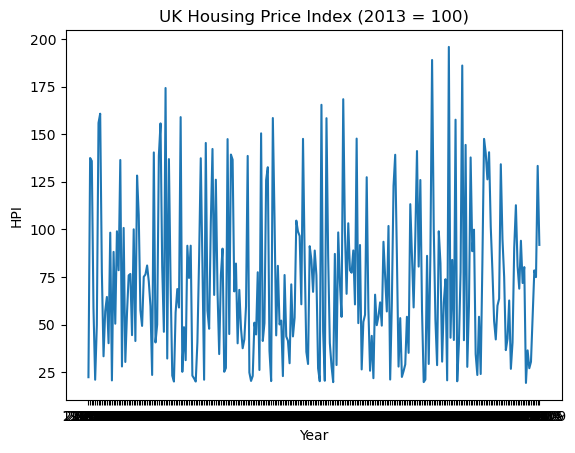

In [10]:
# Visualization Library
import matplotlib.pyplot as plt
%matplotlib inline

# HPI 그래프 생성
plt.plot(hpi_df["yearmm"], hpi_df["hpi"])
plt.xlabel("Year")
plt.ylabel("HPI")
plt.title("UK Housing Price Index (2013 = 100)")
plt.show()

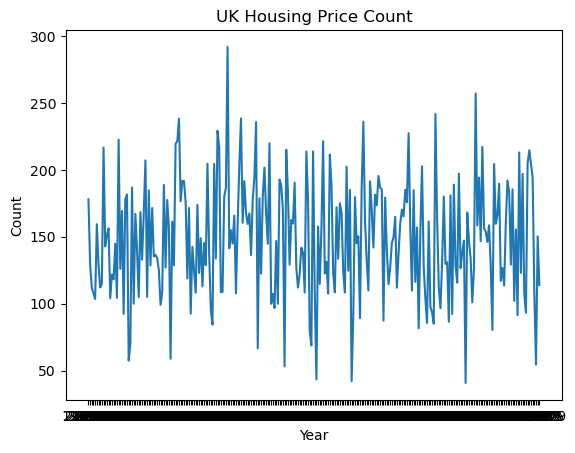

In [11]:
# 거래량 그래프 생성
plt.plot(hpi_df["yearmm"], hpi_df["cnt"])
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("UK Housing Price Count")
plt.show()